## Importance Sampling

Monte Carlo methods use random sampling to obtain numerical results for problems that might be deterministic in principle. One key technique to reduce variance in Monte Carlo estimates is **Importance Sampling**.

- The basic idea of importance sampling is to choose a different probability distribution, $q(x)$, from which to draw your samples, rather than the distribution $p(x)$ you're interested in. This distribution $q(x)$ is called the *proposal distribution* or *importance function*. It should be chosen such that it "over-samples" the regions where $p(x)$ is significantly non-zero and the integrand is large, hence reducing the variance of the estimate.


- It is a method to estimate properties of a particular distribution, while only having samples generated from a different distribution rather than the distribution of interest.


- Consider we are trying to estimate the quantity:

$ E_f[X] = \int f(x) \, p(x) \, dx $

where $f(x)$ is some function, and $p(x)$ is our target probability distribution function.

Instead of sampling directly from the distribution $p(x)$, we introduce a new distribution $q(x)$, from which it is easier to generate samples. We can then rewrite the equation as:

$ E_f[X] = \int \frac{f(x) \, p(x)}{q(x)} \, q(x) \, dx $

This is equivalent to the original equation, as we have simply multiplied and divided by $q(x)$.

However, we can interpret this equation differently: if we draw samples from the distribution $q(x)$, the expected value of $\frac{f(x) \, p(x)}{q(x)}$ under the distribution $q(x)$ gives us an estimate of the integral.

So, to use importance sampling, we draw samples from $q(x)$ and then calculate the average of $\frac{f(x) \, p(x)}{q(x)}$ over these samples. If $q(x)$ is chosen wisely, this can give us a much more accurate estimate of the integral than if we had drawn samples from $p(x)$.

We should choose $q(x)$ such that it is close to $p(x)$ where $f(x)$ is large, which means we want to draw more samples from the regions of the space where $f(x)$ contributes significantly to the integral.

This results in a reduction in variance and an improvement in the accuracy of the integral estimation, because we're focusing our sampling on the "important" regions of the space, i.e., where $f(x) \, p(x)$ is large.

However, a poorly chosen importance distribution can actually increase the variance, so choosing a good importance distribution is a key challenge in importance sampling.


## Example code

# Target and Proposal Distributions

The goal of importance sampling is to estimate properties of a **target distribution** using samples drawn from a different **proposal distribution**. The target and proposal distributions should be defined over the same space.

- ### Target Distribution:
In our example, the target distribution is a standard normal distribution $N(0,1)$. This is the distribution for which we want to estimate the probability that a random variable exceeds the value 3, which is "pretty rare".

- ### Uniform Proposal Distribution:
This is essentially just the target distribution itself, i.e., $N(0,1)$. By naming it "uniform," we indicate that it's a naive choice for importance sampling in this context, as there's no adaptation to focus on the regions of interest.

- ### Good Proposal Distribution:
In our context, since we're interested in the tail of the standard normal distribution (values greater than 3), a good proposal distribution would be one that oversamples from this region. Hence, a shifted normal distribution, $N(3,1)$, is chosen as the "good" proposal. This ensures we sample more values from the area of interest, increasing the efficiency of our estimates.

- ### Poor Proposal Distribution:
On the contrary, a poor proposal distribution for this problem would be one that under-samples the area of interest. The normal distribution $N(-2,1)$ is such an example. Most samples drawn from this distribution will be far away from the threshold of 3, making it a suboptimal choice.

Below is the Python code implementing these distributions and demonstrating the impact of the choice of proposal distribution in importance sampling:

Given this setup, the idea is to compute the expectation of a function with respect to $p$ by instead taking a weighted average over samples drawn from $q$.

The importance weights are computed as:
$ w(x) = \frac{p(x)}{q(x)} $



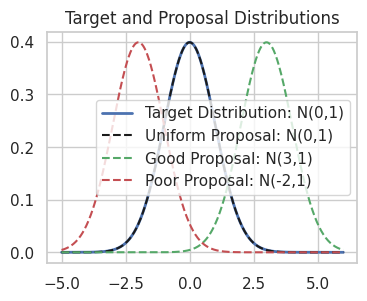

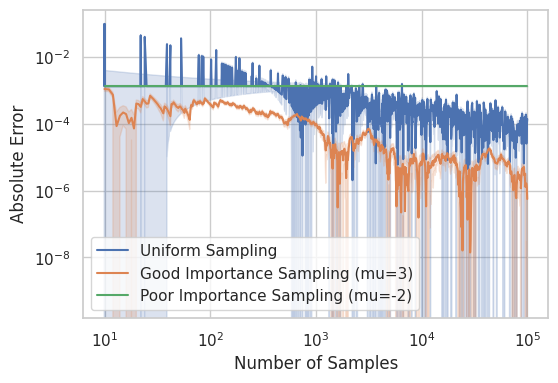

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

# Setting the plotting style for better visualization
sns.set(style='whitegrid')

# Define the function for importance sampling
def importance_sampling(mu_proposal, samples):
    """
    This function calculates the importance weights.
    The weights are the ratio of the probability density of the samples under the target distribution
    and the proposal distribution.

    Parameters:
    - mu_proposal (float): Mean of the proposal distribution.
    - samples (np.array): Array of samples drawn from the proposal distribution.

    Returns:
    - np.array: Array of importance weights.
    """
    weights = norm.pdf(samples, 0, 1) / norm.pdf(samples, mu_proposal, 1)
    return weights

# Define the range for the plot and plot the target and proposal distributions
x = np.linspace(-5, 6, 500)
plt.figure(figsize=(4, 3))
plt.plot(x, norm.pdf(x, 0, 1), label='Target Distribution: N(0,1)', linewidth=2)
plt.plot(x, norm.pdf(x, 0, 1), 'k--', label='Uniform Proposal: N(0,1)')
plt.plot(x, norm.pdf(x, 3, 1), 'g--', label='Good Proposal: N(3,1)')
plt.plot(x, norm.pdf(x, -2, 1), 'r--', label='Poor Proposal: N(-2,1)')
plt.title("Target and Proposal Distributions")
plt.legend()
plt.show()

# Calculate the true probability of a sample being greater than 3 for a standard normal distribution
true_prob = 1 - norm.cdf(3, 0, 1)

# Define the number of iterations and number of samples for each iteration
num_iterations = 1000
num_samples = np.logspace(1, 5, num=num_iterations).astype(int)

# Lists to store the sampling estimates for each method
uniform_samples = []
good_importance_samples = []
poor_importance_samples = []

# Samples from the good proposal distribution
mu_good_proposal = 3
good_importance_raw_samples = np.random.normal(mu_good_proposal, 1, num_samples[-1])

# Samples from the poor proposal distribution
mu_poor_proposal = -2
poor_importance_raw_samples = np.random.normal(mu_poor_proposal, 1, num_samples[-1])

# Iterate through each number of samples and collect estimates
for i in num_samples:
    # Uniform Sampling using the target distribution itself
    uniform_raw_samples = np.random.normal(0, 1, i)
    uniform_samples.append(np.mean(uniform_raw_samples > 3))

    # Importance Sampling using the good proposal distribution
    weights_good = importance_sampling(mu_good_proposal, good_importance_raw_samples[:i])
    good_importance_samples.append(np.mean(weights_good * (good_importance_raw_samples[:i] > 3)))

    # Importance Sampling using the poor proposal distribution
    weights_poor = importance_sampling(mu_poor_proposal, poor_importance_raw_samples[:i])
    poor_importance_samples.append(np.mean(weights_poor * (poor_importance_raw_samples[:i] > 3)))

# Convert lists to numpy arrays for easier manipulation
uniform_samples = np.array(uniform_samples)
good_importance_samples = np.array(good_importance_samples)
poor_importance_samples = np.array(poor_importance_samples)

# Calculate standard errors for each method
uniform_stderrs = np.std(uniform_samples) / np.sqrt(num_samples)
good_importance_stderrs = np.std(good_importance_samples) / np.sqrt(num_samples)
poor_importance_stderrs = np.std(poor_importance_samples) / np.sqrt(num_samples)

# Plotting the absolute errors in estimates for each method, with confidence intervals
plt.figure(figsize=(6, 4))
plt.loglog(num_samples, np.abs(uniform_samples - true_prob), label='Uniform Sampling')
plt.loglog(num_samples, np.abs(good_importance_samples - true_prob), label='Good Importance Sampling (mu=3)')
plt.loglog(num_samples, np.abs(poor_importance_samples - true_prob), label='Poor Importance Sampling (mu=-2)')
plt.fill_between(num_samples, np.abs(uniform_samples - true_prob) - 1.96 * uniform_stderrs,
                 np.abs(uniform_samples - true_prob) + 1.96 * uniform_stderrs, color='C0', alpha=0.2)
plt.fill_between(num_samples, np.abs(good_importance_samples - true_prob) - 1.96 * good_importance_stderrs,
                 np.abs(good_importance_samples - true_prob) + 1.96 * good_importance_stderrs, color='C1', alpha=0.2)
plt.fill_between(num_samples, np.abs(poor_importance_samples - true_prob) - 1.96 * poor_importance_stderrs,
                 np.abs(poor_importance_samples - true_prob) + 1.96 * poor_importance_stderrs, color='C2', alpha=0.2)
plt.xlabel('Number of Samples')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()


##The efficacy of a proposal function in importance sampling
It largely depends on how it covers the region where the target distribution has significant mass, especially the regions of interest (e.g., where a certain condition or threshold is applied).

### 1. Importance Weight

In importance sampling, the weight assigned to each sample is the ratio of its probability under the target distribution to its probability under the proposal distribution:

$ w(x) = \frac{p(x)}{q(x)} $

where $ p(x) $ is the target distribution and $ q(x) $ is the proposal distribution.

### 2. Variance of Estimates

The effectiveness of importance sampling is often judged by the variance of the importance weights. Lower variance in the weights leads to more stable and accurate estimates. The variance of the weights is given by:

$ \text{Var}[w(X)] = E[w(X)^2] - (E[w(X)])^2 $

### 3. Good Proposal Distribution

A "good" proposal distribution will have the following properties:

- It has significant density where the target distribution $ p(x) $ has significant density, ensuring that we sample effectively from areas of interest.
- The ratio $ \frac{p(x)}{q(x)} $ should be close to constant for regions where $ p(x) $ is non-negligible. This will ensure that the importance weights do not have high variance.

In our example, the "good" proposal $ q(x) $ is $ N(3,1) $. This is because we are interested in the tail probability of $ p(x) $ being greater than 3. The proposal $ N(3,1) $ effectively samples from this region, ensuring that we get many samples where $ x > 3 $ and the weights don't vary too much, leading to a more precise estimate.

### 4. Poor Proposal Distribution

A "poor" proposal distribution will:

- Under-sample or even entirely miss regions of interest in the target distribution.
- Lead to a high variance in the importance weights, making estimates unstable and inaccurate.

In our example, the "poor" proposal $ q(x) $ is $ N(-2,1) $. This distribution mostly samples from the left side of the standard normal distribution, rarely from the region where $ x > 3 $. When it does occasionally sample from this region, the importance weight $ \frac{p(x)}{q(x)} $ will be very large because $ q(x) $ is near zero in that region while $ p(x) $ isn't. This leads to a high variance in estimates.

**In summary**, the choice of the proposal distribution in importance sampling is crucial. A good proposal will closely align with the target distribution in regions of interest, leading to more accurate and stable estimates, while a poor one will not, leading to high variance and less accurate estimates.
